In [ ]:
#Import Statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [ ]:
# Define the base path for the data folders
base_path = '2019_2020-selected/'
spline_path = 'spline features/'
linear_path = 'linear features/'

# Read sensor data from both spline and linear features folders
bluetooth_df_spline = pd.read_csv(f'{base_path}{spline_path}bluetooth_2019_2020.csv')
bluetooth_df_linear = pd.read_csv(f'{base_path}{linear_path}bluetooth_2019_2020.csv')

location_df_spline = pd.read_csv(f'{base_path}{spline_path}location_2019_2020.csv')
location_df_linear = pd.read_csv(f'{base_path}{linear_path}location_2019_2020.csv')

screen_df_spline = pd.read_csv(f'{base_path}{spline_path}screen_2019_2020.csv')
screen_df_linear = pd.read_csv(f'{base_path}{linear_path}screen_2019_2020.csv')

sleep_df_spline = pd.read_csv(f'{base_path}{spline_path}sleep_2019_2020.csv')
sleep_df_linear = pd.read_csv(f'{base_path}{linear_path}sleep_2019_2020.csv')

steps_df_spline = pd.read_csv(f'{base_path}{spline_path}steps_2019_2020.csv')
steps_df_linear = pd.read_csv(f'{base_path}{linear_path}steps_2019_2020.csv')

# Read other data files
ema_df = pd.read_csv(f'{base_path}ema_2019_2020.csv')
pre_df = pd.read_csv(f'{base_path}pre_2019_2020.csv')
stress_endterm_df = pd.read_csv(f'{base_path}stress_endterm_2019_2020.csv')

# List of dataframe names
df_names = [
    'bluetooth_df_spline', 'bluetooth_df_linear', 'ema_df', 'location_df_spline', 'location_df_linear',
    'pre_df', 'screen_df_spline', 'screen_df_linear', 'sleep_df_spline', 'sleep_df_linear',
    'steps_df_spline', 'steps_df_linear', 'stress_endterm_df'
]


In [ ]:
# General Renaming Script
def rename_columns(df):
    def rename_col(col):
        # Remove prefixes like 'f_blue:', 'f_steps:', etc.
        col = re.sub(r'^f_\w+:', '', col)
        
        # Replace or simplify repetitive terms
        col = col.replace('rapids_', '').replace('allday_', '')
        
        # Simplify specific metrics
        replacements = {
            'slope_mean': 'slope_mn',
            'slope_variance': 'slope_var',
            'curvature_mean': 'curv_mn',
            'curvature_max': 'curv_max',
            'num_inflection_points': 'inflection_pts',
            'total_variation': 'tot_var',
            'absolute_auc': 'abs_auc',
            'slope': 'slp',
            'mean': 'mn',
            'variance': 'var'
        }
        
        for old, new in replacements.items():
            col = col.replace(old, new)

        # Remove colons to standardize format
        col = col.replace(':', '_')
        
        return col

    # Apply renaming function to all columns in the dataframe
    df.columns = [rename_col(col) if col != 'pid' else 'pid' for col in df.columns]

# Applying the renaming function to all dataframes
dataframes = [bluetooth_df_spline, bluetooth_df_linear, ema_df, location_df_spline, location_df_linear, 
              pre_df, screen_df_spline, screen_df_linear, sleep_df_spline, sleep_df_linear, 
              steps_df_spline, steps_df_linear, stress_endterm_df]

for df in dataframes:
    rename_columns(df)

# Check renamed columns (as an example, printing one dataframe)
print(stress_endterm_df.columns)


In [38]:
# Merge each partition to create dataframes for each category
spline_sensor_dfs = [bluetooth_df_spline, location_df_spline, screen_df_spline, sleep_df_spline, steps_df_spline]
linear_sensor_dfs = [bluetooth_df_linear, location_df_linear, screen_df_linear, sleep_df_linear, steps_df_linear]

# Merge Spline sensor data
df_spline_merged = stress_endterm_df
for df in spline_sensor_dfs:
    df_spline_merged = df_spline_merged.merge(df, on='pid', how='left')

# Merge Linear sensor data
df_linear_merged = stress_endterm_df
for df in linear_sensor_dfs:
    df_linear_merged = df_linear_merged.merge(df, on='pid', how='left')

# Merge Spline and Linear sensor data with distinct suffixes to differentiate features
df_spline_linear_merged = stress_endterm_df
for spline_df, linear_df in zip(spline_sensor_dfs, linear_sensor_dfs):
    df_spline_linear_merged = df_spline_linear_merged.merge(
        spline_df, on='pid', how='left', suffixes=('_spline', ''))
    df_spline_linear_merged = df_spline_linear_merged.merge(
        linear_df, on='pid', how='left', suffixes=('', '_linear'))

# Print the shape of the merged dataframe
print(f'df_spline_linear_merged shape: {df_spline_linear_merged.shape}')

# Merge EMA and PRE with Spline and Linear sensor data
df_ema = stress_endterm_df.merge(ema_df, on='pid', how='left')
df_pre = stress_endterm_df.merge(pre_df, on='pid', how='left')
df_pre_ema = df_pre.merge(ema_df, on='pid', how='left')

# Merge EMA and PRE with Spline sensor data
df_ema_spline = df_spline_merged.merge(ema_df, on='pid', how='left')
df_pre_spline = df_spline_merged.merge(pre_df, on='pid', how='left')
df_pre_ema_spline = df_ema_spline.merge(pre_df, on='pid', how='left')

# Merge EMA and PRE with Linear sensor data
df_ema_linear = df_linear_merged.merge(ema_df, on='pid', how='left')
df_pre_linear = df_linear_merged.merge(pre_df, on='pid', how='left')
df_pre_ema_linear = df_ema_linear.merge(pre_df, on='pid', how='left')

# Remove columns with more than 10% missing values for each partition
def drop_high_missing_cols(df, threshold=0.1):
    missing_rate = df.isnull().mean()
    cols_to_drop = missing_rate[missing_rate > threshold].index
    df.drop(columns=cols_to_drop, inplace=True)
    return df

partitions = [
    df_pre, df_ema, df_pre_ema,
    df_spline_merged, df_linear_merged, df_spline_linear_merged, df_ema_spline, df_pre_spline, df_pre_ema_spline,
    df_ema_linear, df_pre_linear, df_pre_ema_linear
]

# Remove columns with high missing rate and drop remaining rows with NaNs for each partition
for partition_name, partition in zip(
        ['df_pre', 'df_ema', 'df_pre_ema', 'df_spline_merged', 'df_linear_merged', 'df_spline_linear_merged', 
         'df_ema_spline', 'df_pre_spline', 'df_pre_ema_spline', 'df_ema_linear', 'df_pre_linear', 'df_pre_ema_linear'], partitions):
    print(f'\nProcessing partition: {partition_name}')
    drop_high_missing_cols(partition)
    partition.dropna(inplace=True)
    print(f'{partition_name} shape after cleaning: {partition.shape}')

# Print the shape of each partition after dropping columns with high missing rate
for partition_name, partition in zip(
        ['df_pre', 'df_ema', 'df_pre_ema', 'df_spline_merged', 'df_linear_merged', 'df_spline_linear_merged', 
         'df_ema_spline', 'df_pre_spline', 'df_pre_ema_spline', 'df_ema_linear', 'df_pre_linear', 'df_pre_ema_linear'], partitions):
    print(f'{partition_name} shape: {partition.shape}')


df_spline_linear_merged shape: (376, 202)

Processing partition: df_pre
df_pre shape after cleaning: (354, 27)

Processing partition: df_ema
df_ema shape after cleaning: (336, 51)

Processing partition: df_pre_ema
df_pre_ema shape after cleaning: (318, 76)

Processing partition: df_spline_merged
df_spline_merged shape after cleaning: (339, 44)

Processing partition: df_linear_merged
df_linear_merged shape after cleaning: (339, 20)

Processing partition: df_spline_linear_merged
df_spline_linear_merged shape after cleaning: (339, 62)

Processing partition: df_ema_spline
df_ema_spline shape after cleaning: (304, 93)

Processing partition: df_pre_spline
df_pre_spline shape after cleaning: (320, 69)

Processing partition: df_pre_ema_spline
df_pre_ema_spline shape after cleaning: (287, 118)

Processing partition: df_ema_linear
df_ema_linear shape after cleaning: (304, 69)

Processing partition: df_pre_linear
df_pre_linear shape after cleaning: (320, 45)

Processing partition: df_pre_ema_line

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Helper function to evaluate models
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    auc = roc_auc_score(pd.get_dummies(y_test), model.predict_proba(X_test), average='weighted', multi_class='ovr')
    
    print(f"\nModel: {model_name}")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)
    print("ROC-AUC Score:", auc)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues", fmt='g')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Dictionary of Partitions for Evaluation
partition_names = [
    'Spline Sensor Only', 'Linear Sensor Only', 'EMA + Spline Sensor', 'PRE + Spline Sensor', 'PRE + EMA + Spline Sensor',
    'EMA + Linear Sensor', 'PRE + Linear Sensor', 'PRE + EMA + Linear Sensor'
]
partition_data = [
    df_spline_merged, df_linear_merged, df_ema_spline, df_pre_spline, df_pre_ema_spline,
    df_ema_linear, df_pre_linear, df_pre_ema_linear
]

# Dictionary of Models to Evaluate
trained_models = {}

# Iterate over each partition
for partition_name, partition in zip(partition_names, partition_data):
    print(f"\n\n====== Evaluating Partition: {partition_name} ======")

    # Label Encoding for Stress Category
    label_encoder = LabelEncoder()
    partition['stress_category'] = pd.cut(
        partition['PSS_10items_POST'],
        bins=[0, 13, 26, 40],
        labels=['Low', 'Medium', 'High']
    )
    partition['stress_category_encoded'] = label_encoder.fit_transform(partition['stress_category'])

    # Prepare data for training
    X = partition.drop(columns=['pid', 'PSS_10items_POST', 'stress_category', 'stress_category_encoded'])
    y = partition['stress_category_encoded']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # Apply feature scaling
    scaler = RobustScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Model Definitions
    models = {
        'Random Forest': RandomForestClassifier(random_state=42),
        'XGBoost': XGBClassifier(random_state=42, eval_metric='mlogloss'),
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'SVC': SVC(probability=True, random_state=42),
        'MLP Classifier': MLPClassifier(max_iter=500, random_state=42)
    }

    # Stratified K-Fold Cross Validation
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # Train and evaluate each model
    for model_name, model in models.items():
        print(f"Training and evaluating {model_name} for {partition_name} partition...")
        
        # Perform cross-validation on the training data
        cross_val_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1_weighted')
        print(f"{model_name} Cross-Validation F1 Score: {cross_val_scores.mean():.4f}")

        # Fit the model to the training data
        model.fit(X_train, y_train)
        
        # Store the trained model
        trained_models[(partition_name, model_name)] = model

        # Evaluate model performance
        evaluate_model(model, X_test, y_test, f"{model_name} - {partition_name}")


In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score, \
    precision_score, recall_score, f1_score, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Helper function to evaluate models
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    auc = roc_auc_score(pd.get_dummies(y_test), model.predict_proba(X_test), average='weighted', multi_class='ovr')
    auc_pr = average_precision_score(pd.get_dummies(y_test), model.predict_proba(X_test), average='weighted')
    
    
    print(f"\nModel: {model_name}")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)
    print("ROC-AUC Score:", auc)
    print("AUC-PR Score:", auc_pr)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues", fmt='g')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Feature Selection based on LASSO
def select_features_based_on_lasso(df):
    import warnings
    from sklearn.exceptions import ConvergenceWarning
    warnings.filterwarnings('ignore', category=ConvergenceWarning)
    
    X = df.drop(columns=['PSS_10items_POST', 'pid', 'stress_category', 'stress_category_encoded'], errors='ignore')
    y = df['PSS_10items_POST']
    
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)
    X_normalized = pd.DataFrame(X_normalized, columns=X.columns)
    
    lasso = Lasso(max_iter=100000, tol=1e-4)
    lasso.fit(X_normalized, y)
    
    selected_features = np.where(lasso.coef_ != 0)[0]
    selected_feature_names = X.columns[selected_features].tolist()
    
    return selected_feature_names

# Dictionary of Partitions for Evaluation
partition_names = [
    'Spline Sensor Only', 'Linear Sensor Only', 'EMA + Spline Sensor', 'PRE + Spline Sensor', 'PRE + EMA + Spline Sensor',
    'EMA + Linear Sensor', 'PRE + Linear Sensor', 'PRE + EMA + Linear Sensor'
]
partition_data = [
    df_spline_merged, df_linear_merged, df_ema_spline, df_pre_spline, df_pre_ema_spline,
    df_ema_linear, df_pre_linear, df_pre_ema_linear
]

# Model Definitions
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='mlogloss'),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVC': SVC(probability=True, random_state=42),
    'MLP Classifier': MLPClassifier(max_iter=500, random_state=42)
}
# Dictionary to store trained models
trained_models = {}
# Iterate over each partition and train models
for partition_name, partition in zip(partition_names, partition_data):
    print(f'\nEvaluating Partition: {partition_name}')

    # Label Encoding for Stress Category
    label_encoder = LabelEncoder()
    partition['stress_category'] = pd.cut(
        partition['PSS_10items_POST'],
        bins=[0, 13, 26, 40],
        labels=['Low', 'Medium', 'High']
    )
    partition['stress_category_encoded'] = label_encoder.fit_transform(partition['stress_category'])

    # Feature Selection using LASSO
    selected_features = select_features_based_on_lasso(partition)
    X = partition[selected_features]
    y = partition['stress_category_encoded']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # Apply feature scaling
    scaler = RobustScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Stratified K-Fold Cross Validation
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # Train and evaluate each model
    for model_name, model in models.items():
        print(f'Training and evaluating {model_name} for {partition_name} partition...')
        
        # Hyperparameter Tuning using RandomizedSearchCV
        if model_name == 'Random Forest':
            param_dist = {
                'n_estimators': [100, 200, 300],
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10]
            }
            model = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=5, cv=kfold, random_state=42)
        elif model_name == 'XGBoost':
            param_dist = {
                'n_estimators': [100, 200, 300],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 6, 10]
            }
            model = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=5, cv=kfold, random_state=42)
        elif model_name == 'SVC':
            param_dist = {
                'C': [0.1, 1, 10],
                'kernel': ['linear', 'rbf']
            }
            model = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=5, cv=kfold, random_state=42)

        # Fit the model to the training data
        model.fit(X_train, y_train)
        
        # Store the trained model
        trained_models[(partition_name, model_name)] = model

        # Evaluate model performance
        evaluate_model(model, X_test, y_test, f'{model_name} - {partition_name}')



Evaluating Partition: Spline and Linear Sensor Merged
Training and evaluating Random Forest for Spline and Linear Sensor Merged partition...

Model: Random Forest - Spline and Linear Sensor Merged
Accuracy: 0.5441176470588235
Precision: 0.44187437686939185
Recall: 0.5441176470588235
F1-Score: 0.4747219276059939
ROC-AUC Score: 0.4893240950226244
AUC-PR Score: 0.4866542564436083


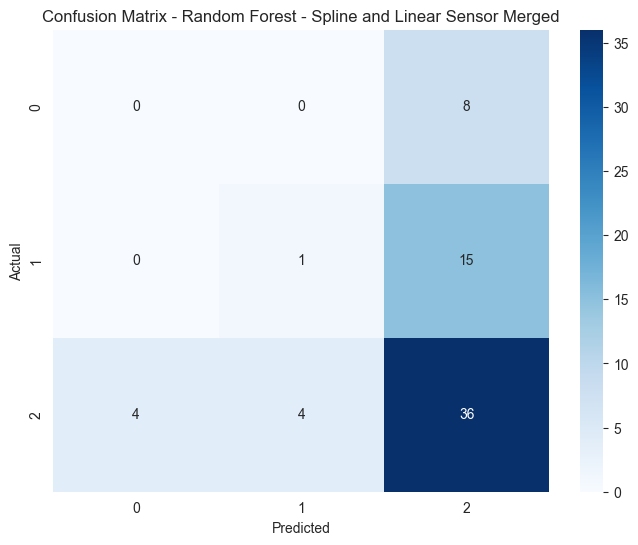

Training and evaluating XGBoost for Spline and Linear Sensor Merged partition...

Model: XGBoost - Spline and Linear Sensor Merged
Accuracy: 0.5441176470588235
Precision: 0.4645437122217308
Recall: 0.5441176470588235
F1-Score: 0.489377326479451
ROC-AUC Score: 0.5495475113122171
AUC-PR Score: 0.5279258944825909


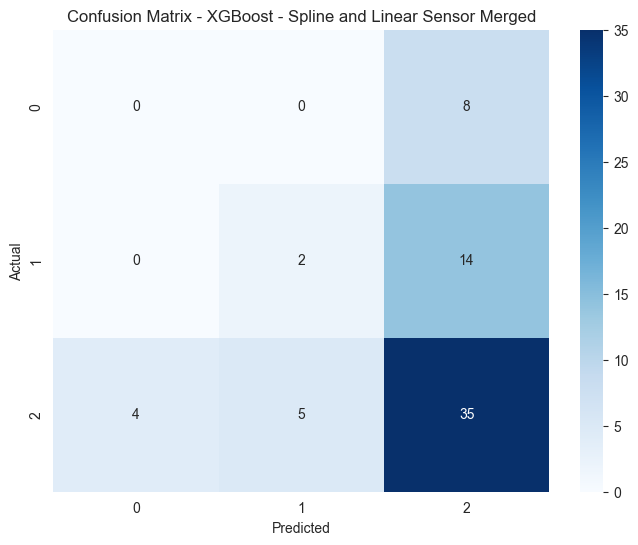

Training and evaluating Logistic Regression for Spline and Linear Sensor Merged partition...

Model: Logistic Regression - Spline and Linear Sensor Merged
Accuracy: 0.6470588235294118
Precision: 0.41868512110726647
Recall: 0.6470588235294118
F1-Score: 0.5084033613445378
ROC-AUC Score: 0.5372454751131222
AUC-PR Score: 0.5356985623099284


/Users/praneelpanchigar/PycharmProjects/AIforHealth/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


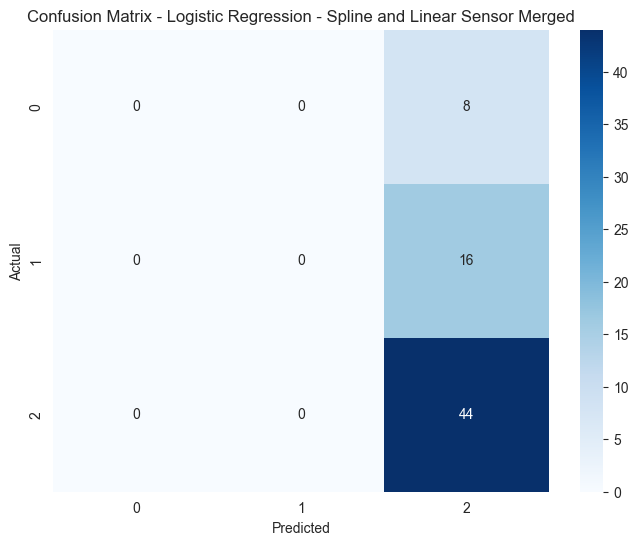

Training and evaluating SVC for Spline and Linear Sensor Merged partition...

Model: SVC - Spline and Linear Sensor Merged
Accuracy: 0.6470588235294118
Precision: 0.41868512110726647
Recall: 0.6470588235294118
F1-Score: 0.5084033613445378
ROC-AUC Score: 0.46079374057315237
AUC-PR Score: 0.49172843036630215


/Users/praneelpanchigar/PycharmProjects/AIforHealth/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


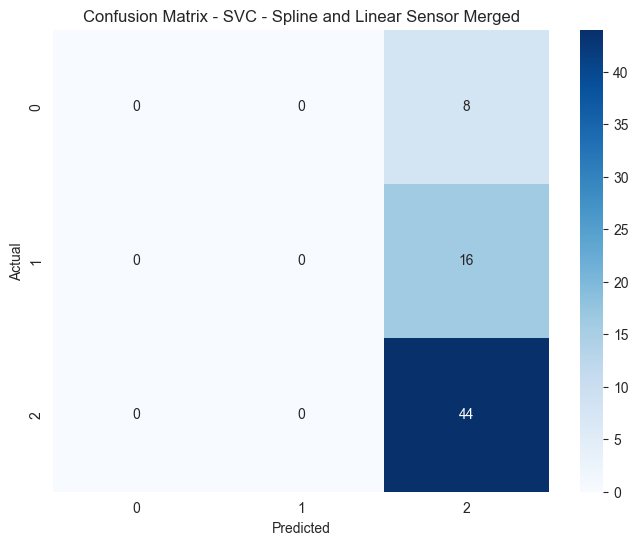

/Users/praneelpanchigar/PycharmProjects/AIforHealth/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training and evaluating MLP Classifier for Spline and Linear Sensor Merged partition...

Model: MLP Classifier - Spline and Linear Sensor Merged
Accuracy: 0.6470588235294118
Precision: 0.41868512110726647
Recall: 0.6470588235294118
F1-Score: 0.5084033613445378
ROC-AUC Score: 0.4966817496229261
AUC-PR Score: 0.5048246471941302


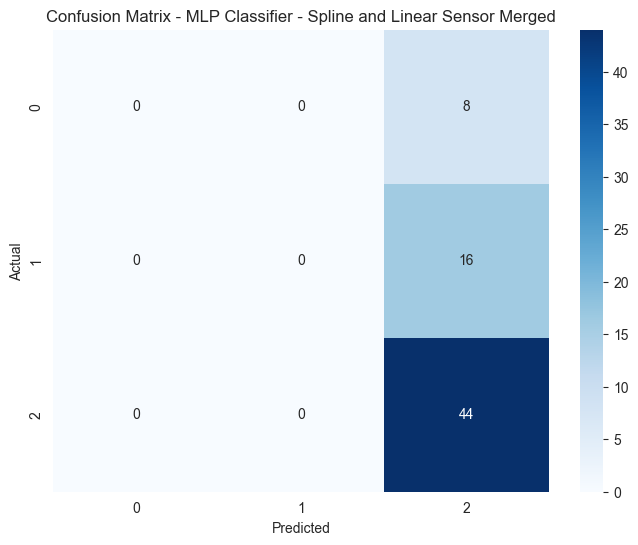


Evaluating Partition: PRE only
Training and evaluating Random Forest for PRE only partition...

Model: Random Forest - PRE only
Accuracy: 0.676056338028169
Precision: 0.6574558461882405
Recall: 0.676056338028169
F1-Score: 0.6568959913326111
ROC-AUC Score: 0.7124848209491554
AUC-PR Score: 0.6897262255652299


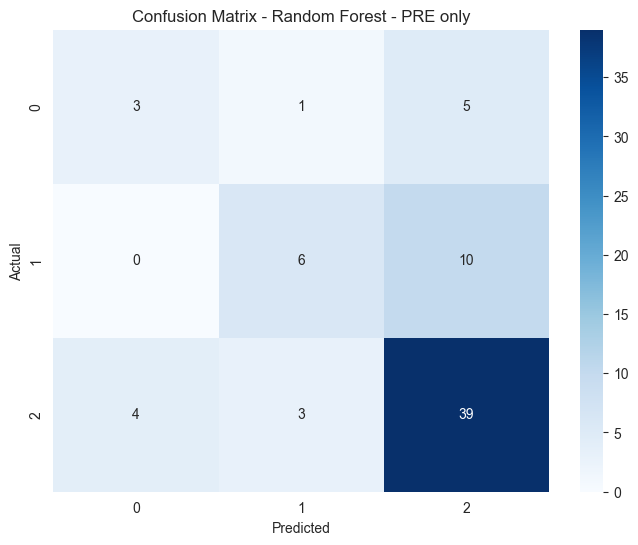

Training and evaluating XGBoost for PRE only partition...

Model: XGBoost - PRE only
Accuracy: 0.5633802816901409
Precision: 0.5585128417564209
Recall: 0.5633802816901409
F1-Score: 0.5607943561547538
ROC-AUC Score: 0.6344876295898558
AUC-PR Score: 0.6110050675353252


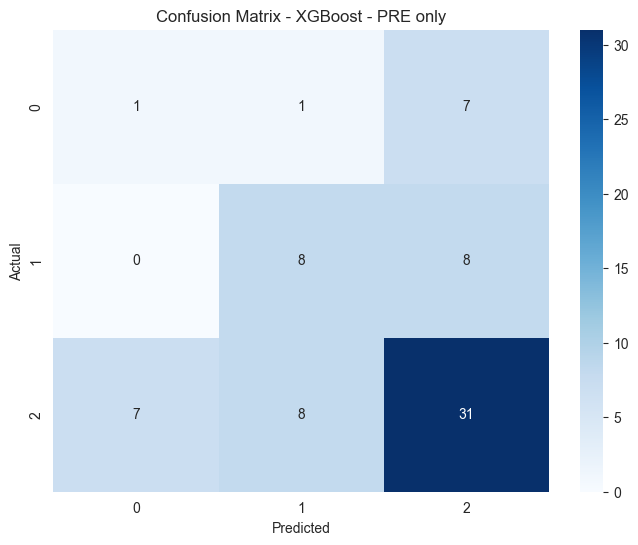

Training and evaluating Logistic Regression for PRE only partition...

Model: Logistic Regression - PRE only
Accuracy: 0.7323943661971831
Precision: 0.7319699742712394
Recall: 0.7323943661971831
F1-Score: 0.699101274312542
ROC-AUC Score: 0.7846590392796663
AUC-PR Score: 0.7396673623082141


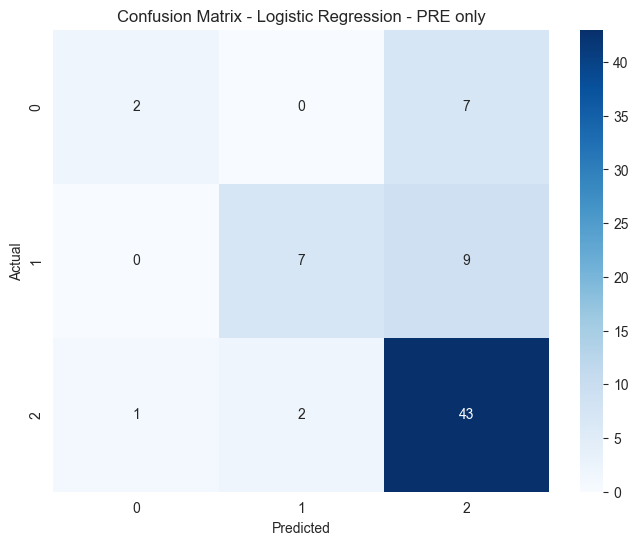

Training and evaluating SVC for PRE only partition...

Model: SVC - PRE only
Accuracy: 0.647887323943662
Precision: 0.6117706237424547
Recall: 0.647887323943662
F1-Score: 0.6175605670220418
ROC-AUC Score: 0.6408202882987072
AUC-PR Score: 0.5991918417936122


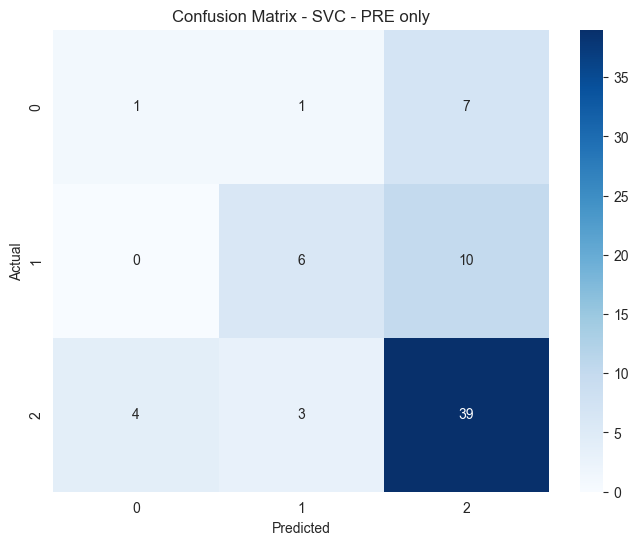

Training and evaluating MLP Classifier for PRE only partition...

Model: MLP Classifier - PRE only
Accuracy: 0.676056338028169
Precision: 0.6500782472613458
Recall: 0.676056338028169
F1-Score: 0.6542454728370222
ROC-AUC Score: 0.7348527528809219
AUC-PR Score: 0.6997011148821439


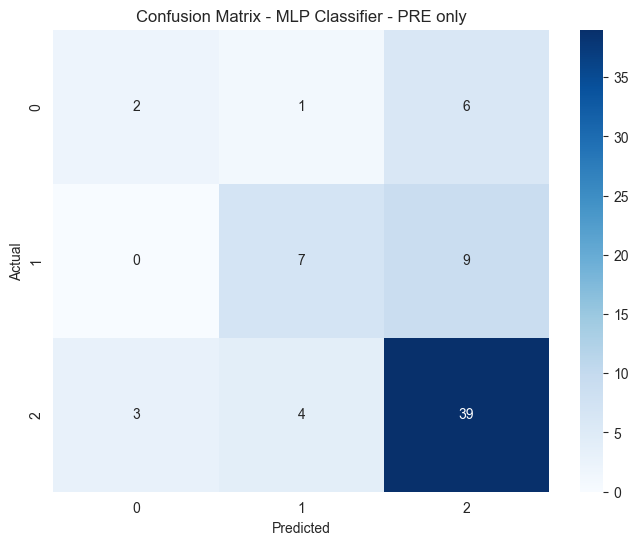


Evaluating Partition: EMA only
Training and evaluating Random Forest for EMA only partition...

Model: Random Forest - EMA only
Accuracy: 0.6617647058823529
Precision: 0.6549188640973631
Recall: 0.6617647058823529
F1-Score: 0.6179135731962688
ROC-AUC Score: 0.6838901572255857
AUC-PR Score: 0.669876565643836


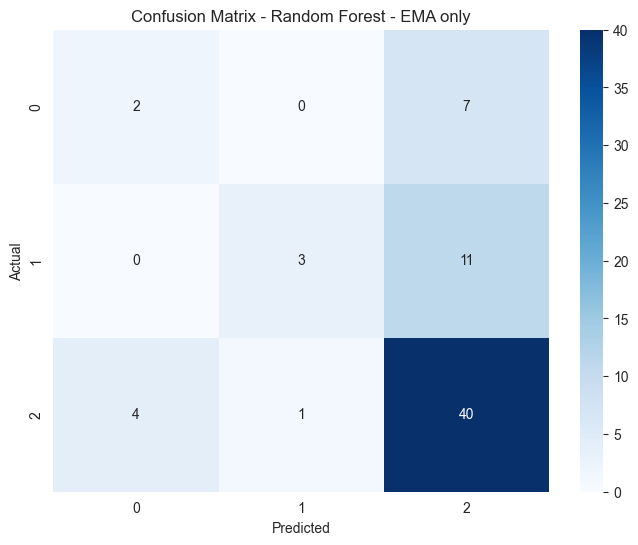

Training and evaluating XGBoost for EMA only partition...

Model: XGBoost - EMA only
Accuracy: 0.5882352941176471
Precision: 0.49396008403361347
Recall: 0.5882352941176471
F1-Score: 0.5344896622015143
ROC-AUC Score: 0.7213346875637179
AUC-PR Score: 0.6844226094118185


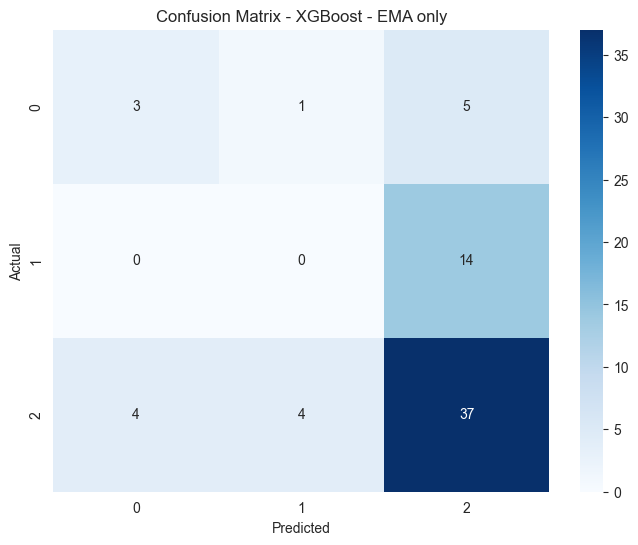

Training and evaluating Logistic Regression for EMA only partition...

Model: Logistic Regression - EMA only
Accuracy: 0.7205882352941176
Precision: 0.7279411764705882
Recall: 0.7205882352941176
F1-Score: 0.67173023055376
ROC-AUC Score: 0.7833729086492536
AUC-PR Score: 0.7470774515156869


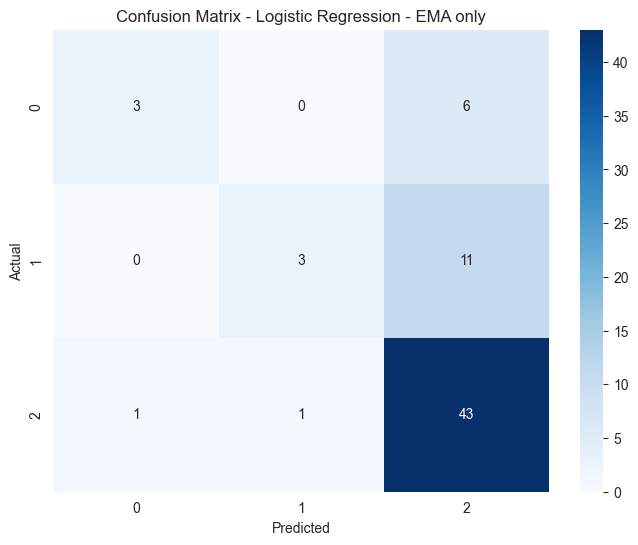

Training and evaluating SVC for EMA only partition...

Model: SVC - EMA only
Accuracy: 0.6764705882352942
Precision: 0.6428571428571429
Recall: 0.6764705882352942
F1-Score: 0.5968137254901961
ROC-AUC Score: 0.7518031653830778
AUC-PR Score: 0.7197433363732744


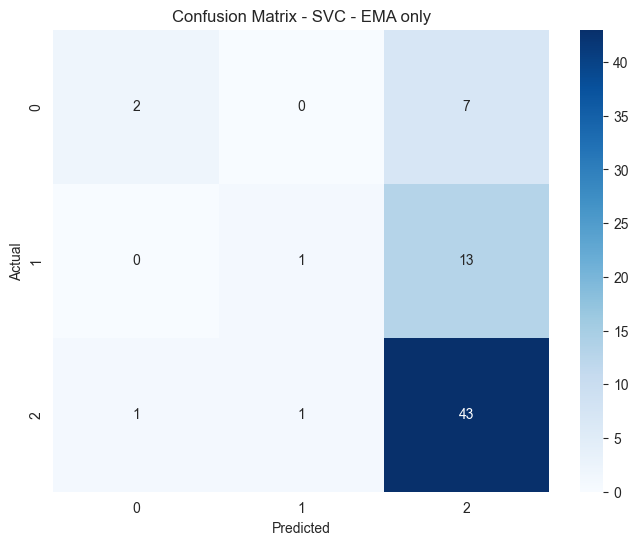

Training and evaluating MLP Classifier for EMA only partition...

Model: MLP Classifier - EMA only
Accuracy: 0.6617647058823529
Precision: 0.6299894957983192
Recall: 0.6617647058823529
F1-Score: 0.6257716948165405
ROC-AUC Score: 0.752095765842569
AUC-PR Score: 0.7290883831815649


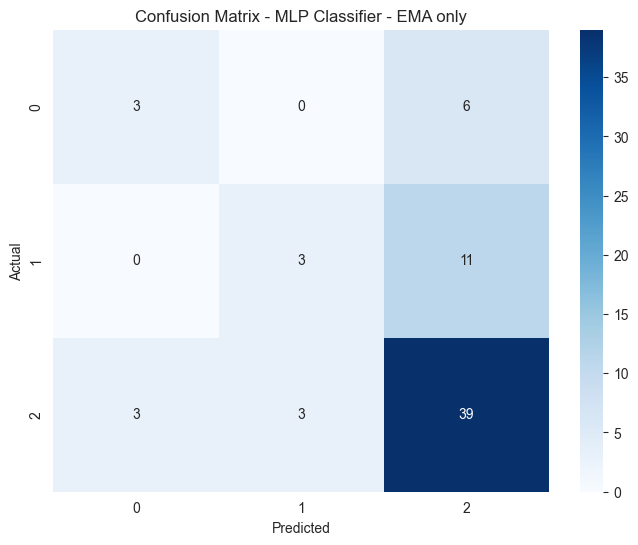


Evaluating Partition: PRE + EMA
Training and evaluating Random Forest for PRE + EMA partition...

Model: Random Forest - PRE + EMA
Accuracy: 0.625
Precision: 0.623729531338227
Recall: 0.625
F1-Score: 0.6147727272727272
ROC-AUC Score: 0.7256963012477717
AUC-PR Score: 0.705354249550068


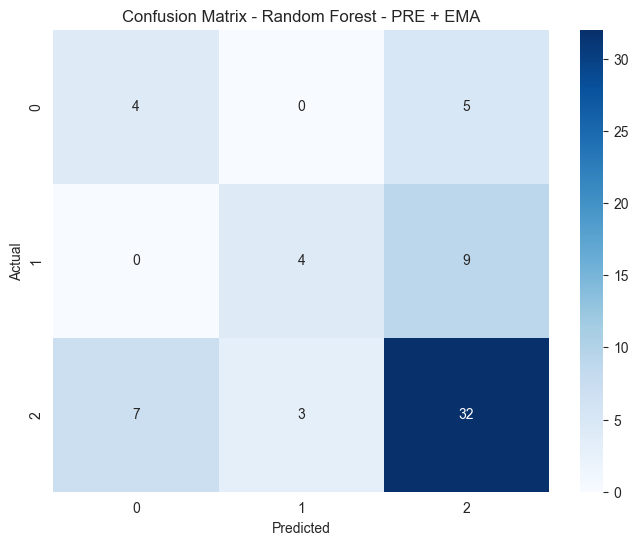

Training and evaluating XGBoost for PRE + EMA partition...

Model: XGBoost - PRE + EMA
Accuracy: 0.578125
Precision: 0.5728456227638641
Recall: 0.578125
F1-Score: 0.5697502864782277
ROC-AUC Score: 0.6523117201426025
AUC-PR Score: 0.6158918298269814


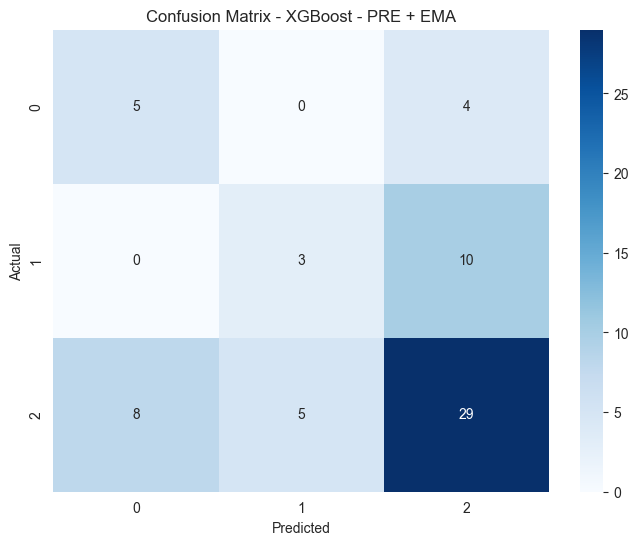

Training and evaluating Logistic Regression for PRE + EMA partition...

Model: Logistic Regression - PRE + EMA
Accuracy: 0.6875
Precision: 0.6829710144927535
Recall: 0.6875
F1-Score: 0.6803977272727273
ROC-AUC Score: 0.697927807486631
AUC-PR Score: 0.6346380167516786


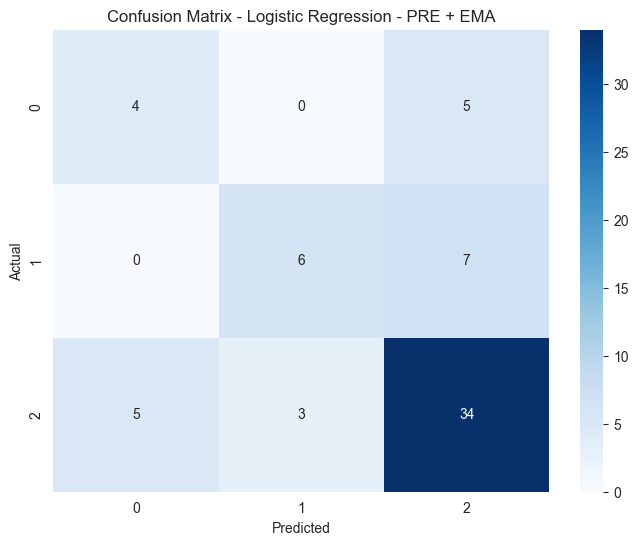

Training and evaluating SVC for PRE + EMA partition...

Model: SVC - PRE + EMA
Accuracy: 0.671875
Precision: 0.6559709821428572
Recall: 0.671875
F1-Score: 0.6542682577838828
ROC-AUC Score: 0.6831105169340463
AUC-PR Score: 0.6440181034525615


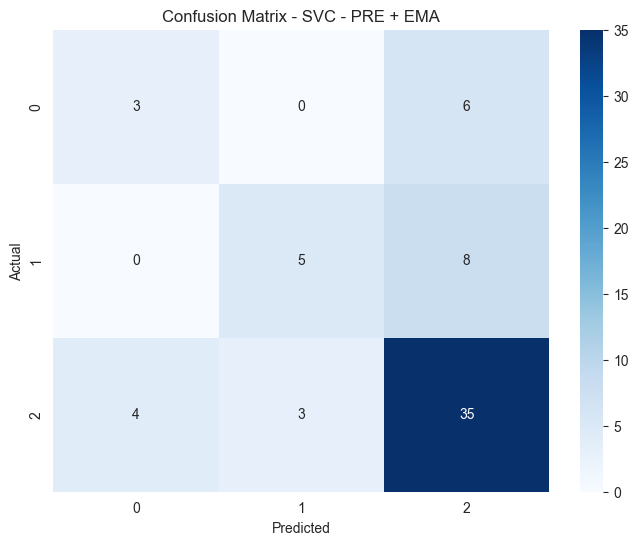

Training and evaluating MLP Classifier for PRE + EMA partition...

Model: MLP Classifier - PRE + EMA
Accuracy: 0.65625
Precision: 0.6507799265951439
Recall: 0.65625
F1-Score: 0.64375
ROC-AUC Score: 0.6781472816399285
AUC-PR Score: 0.6399450845342614


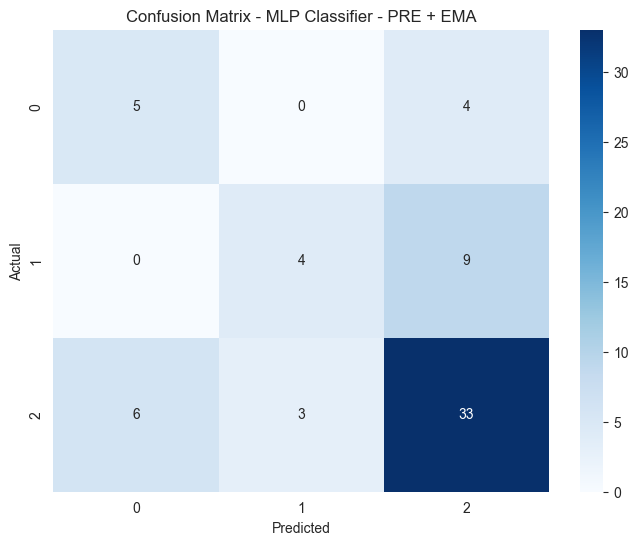


Evaluating Partition: EMA + Linear Sensor
Training and evaluating Random Forest for EMA + Linear Sensor partition...

Model: Random Forest - EMA + Linear Sensor
Accuracy: 0.7213114754098361
Precision: 0.7198594847775176
Recall: 0.7213114754098361
F1-Score: 0.6902840329069837
ROC-AUC Score: 0.7145318999854813
AUC-PR Score: 0.7007323474961935


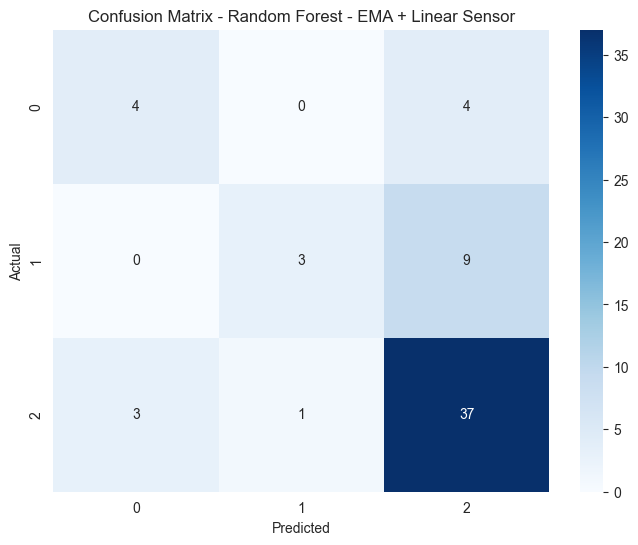

Training and evaluating XGBoost for EMA + Linear Sensor partition...

Model: XGBoost - EMA + Linear Sensor
Accuracy: 0.6557377049180327
Precision: 0.596469104665826
Recall: 0.6557377049180327
F1-Score: 0.6027951952859409
ROC-AUC Score: 0.6102804623241193
AUC-PR Score: 0.6338646597344487


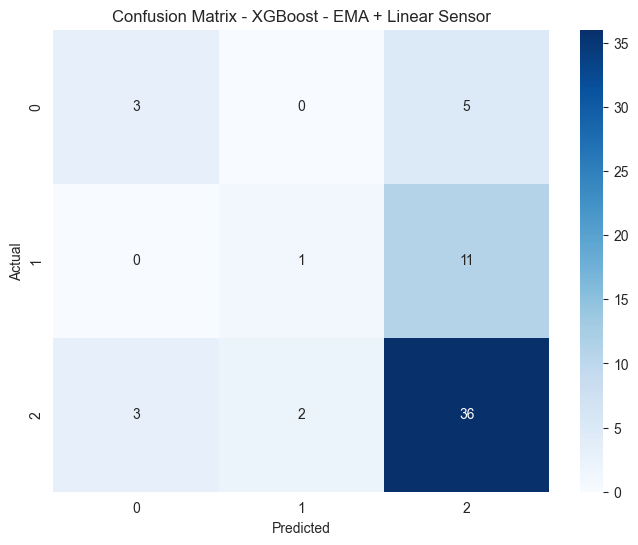

Training and evaluating Logistic Regression for EMA + Linear Sensor partition...

Model: Logistic Regression - EMA + Linear Sensor
Accuracy: 0.6885245901639344
Precision: 0.6640395124001681
Recall: 0.6885245901639344
F1-Score: 0.6480778167716296
ROC-AUC Score: 0.7383528914194815
AUC-PR Score: 0.7091051118367387


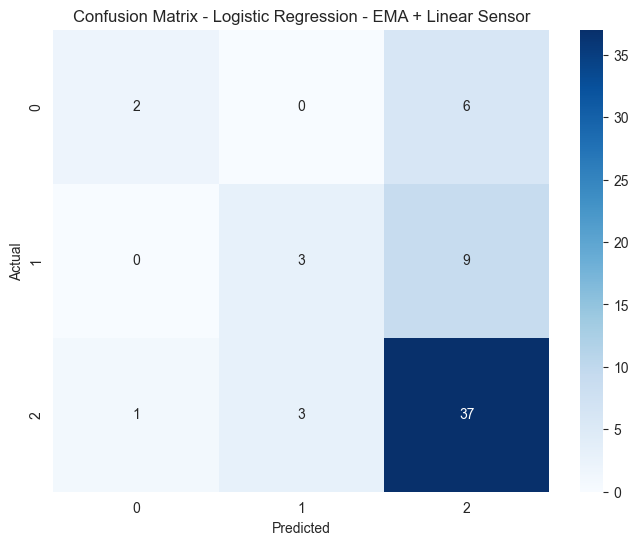

Training and evaluating SVC for EMA + Linear Sensor partition...

Model: SVC - EMA + Linear Sensor
Accuracy: 0.6885245901639344
Precision: 0.6587735276259866
Recall: 0.6885245901639344
F1-Score: 0.634575260804769
ROC-AUC Score: 0.68377794049881
AUC-PR Score: 0.6682867051073447


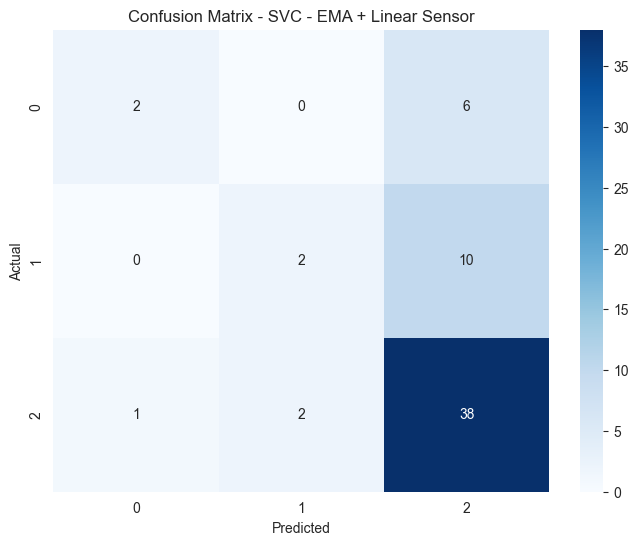

Training and evaluating MLP Classifier for EMA + Linear Sensor partition...

Model: MLP Classifier - EMA + Linear Sensor
Accuracy: 0.6885245901639344
Precision: 0.655296343001261
Recall: 0.6885245901639344
F1-Score: 0.6466751692744787
ROC-AUC Score: 0.7459467733892196
AUC-PR Score: 0.7314672467287449


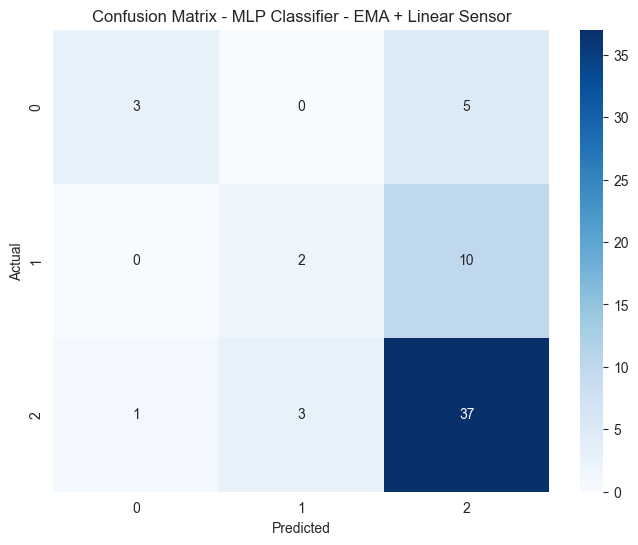


Evaluating Partition: PRE + Linear Sensor
Training and evaluating Random Forest for PRE + Linear Sensor partition...

Model: Random Forest - PRE + Linear Sensor
Accuracy: 0.703125
Precision: 0.6897578983516484
Recall: 0.703125
F1-Score: 0.6718949733062637
ROC-AUC Score: 0.6736262269853595
AUC-PR Score: 0.6646377978139562


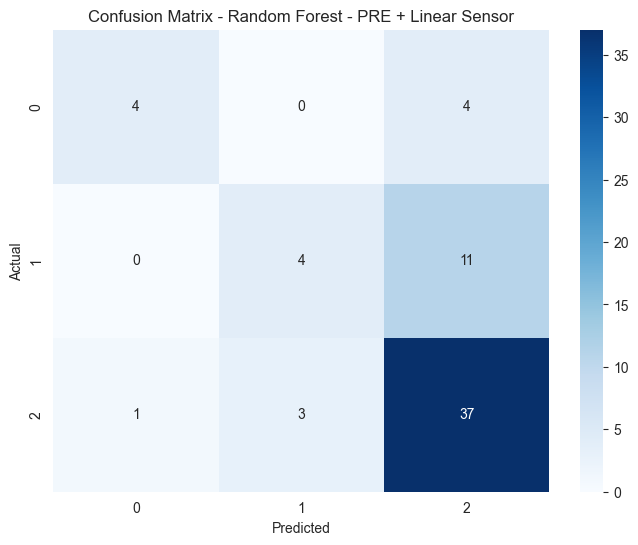

Training and evaluating XGBoost for PRE + Linear Sensor partition...

Model: XGBoost - PRE + Linear Sensor
Accuracy: 0.640625
Precision: 0.5369073275862069
Recall: 0.640625
F1-Score: 0.558757215007215
ROC-AUC Score: 0.6537128438331854
AUC-PR Score: 0.6277941226876508


/Users/praneelpanchigar/PycharmProjects/AIforHealth/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


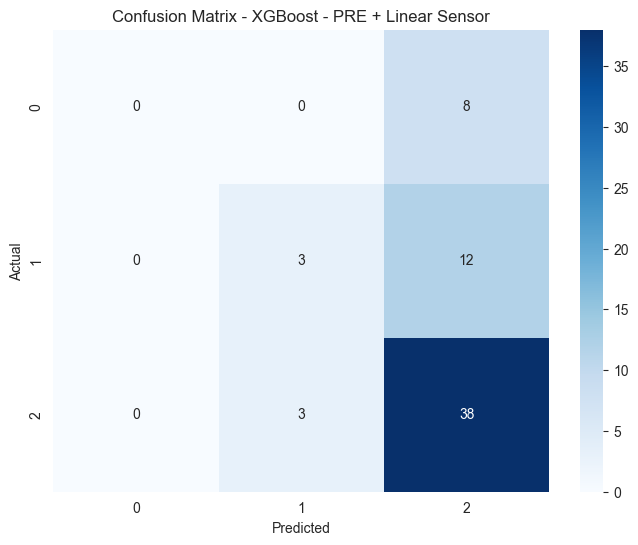

Training and evaluating Logistic Regression for PRE + Linear Sensor partition...

Model: Logistic Regression - PRE + Linear Sensor
Accuracy: 0.65625
Precision: 0.5640889830508475
Recall: 0.65625
F1-Score: 0.5700000000000001
ROC-AUC Score: 0.745655293367347
AUC-PR Score: 0.706618491147635


/Users/praneelpanchigar/PycharmProjects/AIforHealth/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


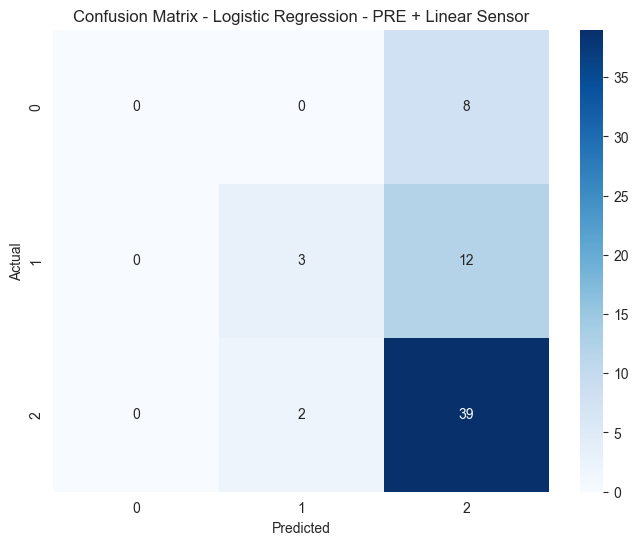

Training and evaluating SVC for PRE + Linear Sensor partition...

Model: SVC - PRE + Linear Sensor
Accuracy: 0.640625
Precision: 0.5369073275862069
Recall: 0.640625
F1-Score: 0.558757215007215
ROC-AUC Score: 0.589755365461402
AUC-PR Score: 0.6180249665787456


/Users/praneelpanchigar/PycharmProjects/AIforHealth/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


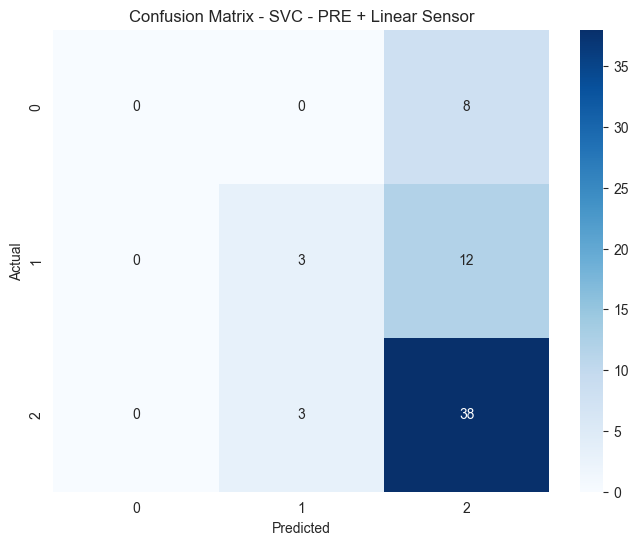

Training and evaluating MLP Classifier for PRE + Linear Sensor partition...

Model: MLP Classifier - PRE + Linear Sensor
Accuracy: 0.640625
Precision: 0.5369073275862069
Recall: 0.640625
F1-Score: 0.558757215007215
ROC-AUC Score: 0.7131644437666371
AUC-PR Score: 0.7162647335552117


/Users/praneelpanchigar/PycharmProjects/AIforHealth/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


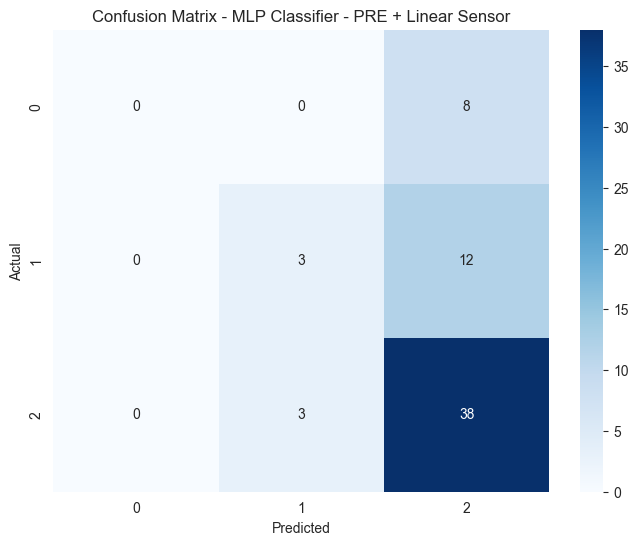


Evaluating Partition: PRE + EMA + Linear Sensor
Training and evaluating Random Forest for PRE + EMA + Linear Sensor partition...

Model: Random Forest - PRE + EMA + Linear Sensor
Accuracy: 0.7068965517241379
Precision: 0.6875701684041701
Recall: 0.7068965517241379
F1-Score: 0.6917688526883929
ROC-AUC Score: 0.8169790104947526
AUC-PR Score: 0.8063866648869016


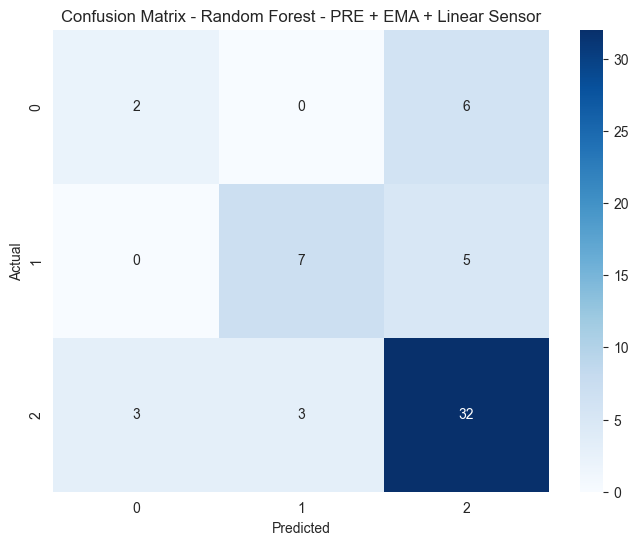

Training and evaluating XGBoost for PRE + EMA + Linear Sensor partition...

Model: XGBoost - PRE + EMA + Linear Sensor
Accuracy: 0.6896551724137931
Precision: 0.6789819376026273
Recall: 0.6896551724137931
F1-Score: 0.6806202418271383
ROC-AUC Score: 0.7757271364317841
AUC-PR Score: 0.7353973620383099


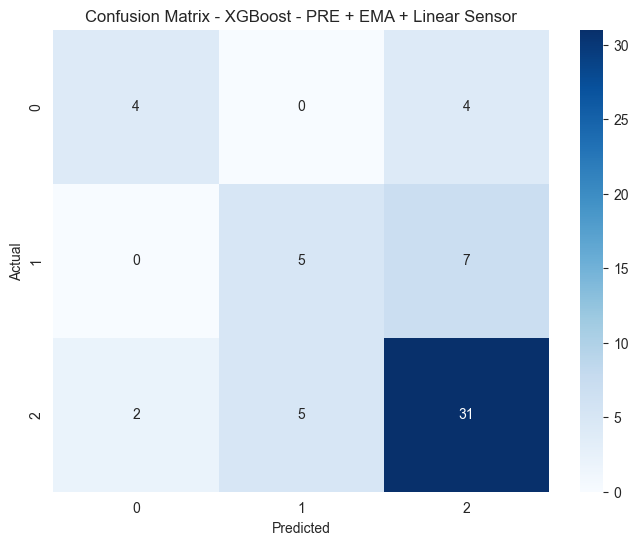

Training and evaluating Logistic Regression for PRE + EMA + Linear Sensor partition...

Model: Logistic Regression - PRE + EMA + Linear Sensor
Accuracy: 0.7241379310344828
Precision: 0.7233800682076544
Recall: 0.7241379310344828
F1-Score: 0.7232183908045977
ROC-AUC Score: 0.805599700149925
AUC-PR Score: 0.8004476450624373


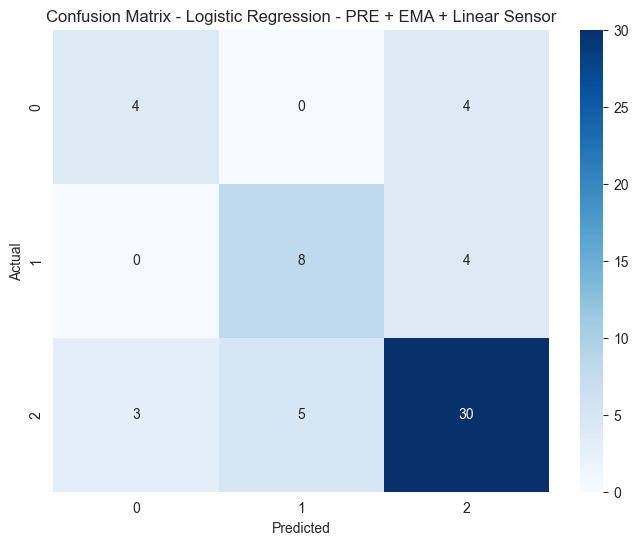

Training and evaluating SVC for PRE + EMA + Linear Sensor partition...

Model: SVC - PRE + EMA + Linear Sensor
Accuracy: 0.7241379310344828
Precision: 0.7327586206896551
Recall: 0.7241379310344828
F1-Score: 0.7112419400056069
ROC-AUC Score: 0.8000524737631184
AUC-PR Score: 0.7952360150522692


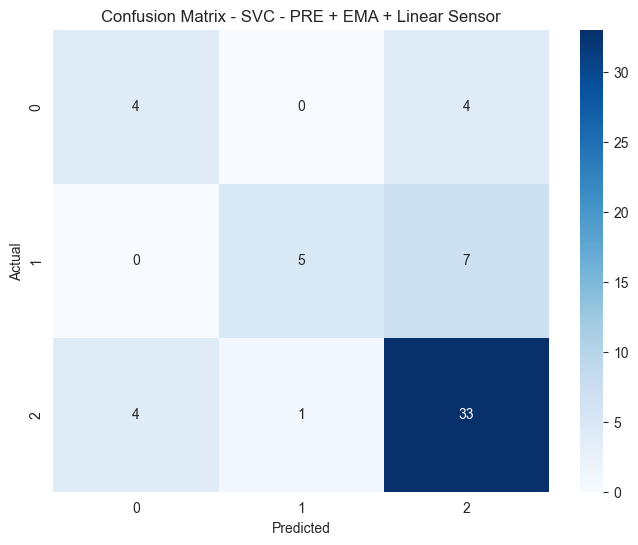

Training and evaluating MLP Classifier for PRE + EMA + Linear Sensor partition...

Model: MLP Classifier - PRE + EMA + Linear Sensor
Accuracy: 0.6724137931034483
Precision: 0.6616604589691216
Recall: 0.6724137931034483
F1-Score: 0.6652064071531554
ROC-AUC Score: 0.7846476761619192
AUC-PR Score: 0.7577726969498512


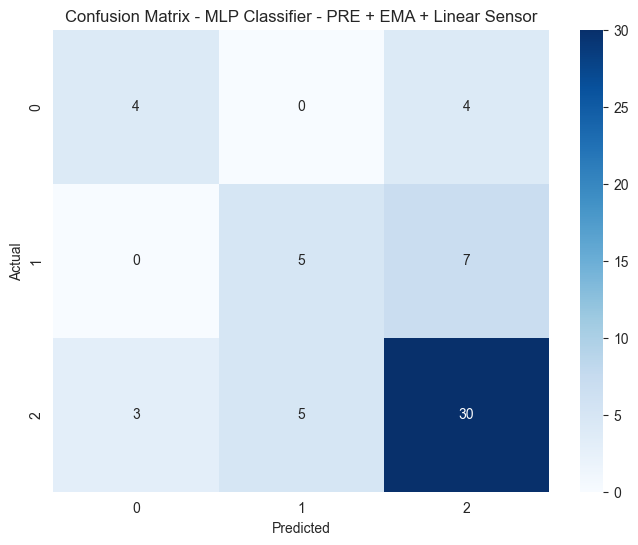

In [50]:
# Dictionary of Partitions for Evaluation
partition_names = [
    'Spline and Linear Sensor Merged', 'PRE only', 'EMA only', 'PRE + EMA',
    'EMA + Linear Sensor', 'PRE + Linear Sensor', 'PRE + EMA + Linear Sensor'
]
partition_data = [
    df_spline_linear_merged, df_pre, df_ema, df_pre_ema,
    df_ema_linear, df_pre_linear, df_pre_ema_linear
]

# Model Definitions
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='mlogloss'),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVC': SVC(probability=True, random_state=42),
    'MLP Classifier': MLPClassifier(max_iter=500, random_state=42)
}
# Dictionary to store trained models
trained_models = {}
#Selected Features Dict
selected_features_dict = {}
# Iterate over each partition and train models
for partition_name, partition in zip(partition_names, partition_data):
    print(f'\nEvaluating Partition: {partition_name}')

    # Label Encoding for Stress Category
    label_encoder = LabelEncoder()
    partition['stress_category'] = pd.cut(
        partition['PSS_10items_POST'],
        bins=[0, 13, 26, 40],
        labels=['Low', 'Medium', 'High']
    )
    partition['stress_category_encoded'] = label_encoder.fit_transform(partition['stress_category'])

    # Feature Selection using LASSO
    selected_features = select_features_based_on_lasso(partition)
    # Ensure 'pid' is not in selected features
    selected_features = [feature for feature in selected_features if feature != 'pid']
    selected_features_dict[partition_name] = selected_features

    X = partition[selected_features]
    y = partition['stress_category_encoded']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # Apply feature scaling
    scaler = RobustScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Stratified K-Fold Cross Validation
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    

    # Train and evaluate each model
    for model_name, model in models.items():
        print(f'Training and evaluating {model_name} for {partition_name} partition...')
        
        # Hyperparameter Tuning using RandomizedSearchCV
        if model_name == 'Random Forest':
            param_dist = {
                'n_estimators': [100, 200, 300],
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10]
            }
            model = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=5, cv=kfold, random_state=42)
        elif model_name == 'XGBoost':
            param_dist = {
                'n_estimators': [100, 200, 300],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 6, 10]
            }
            model = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=5, cv=kfold, random_state=42)
        elif model_name == 'SVC':
            param_dist = {
                'C': [0.1, 1, 10],
                'kernel': ['linear', 'rbf']
            }
            model = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=5, cv=kfold, random_state=42)

        # Fit the model to the training data
        model.fit(X_train, y_train)
        
        # Store the trained model
        trained_models[(partition_name, model_name)] = model

        # Evaluate model performance
        evaluate_model(model, X_test, y_test, f'{model_name} - {partition_name}')


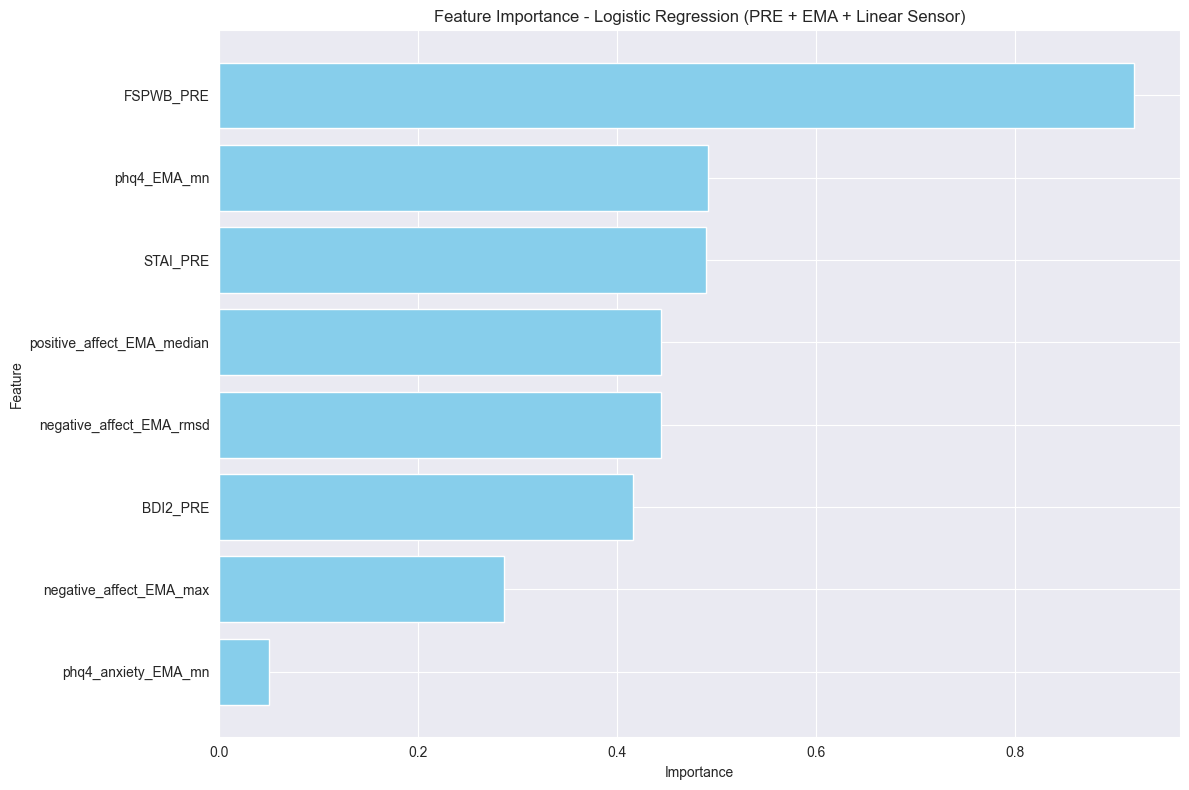

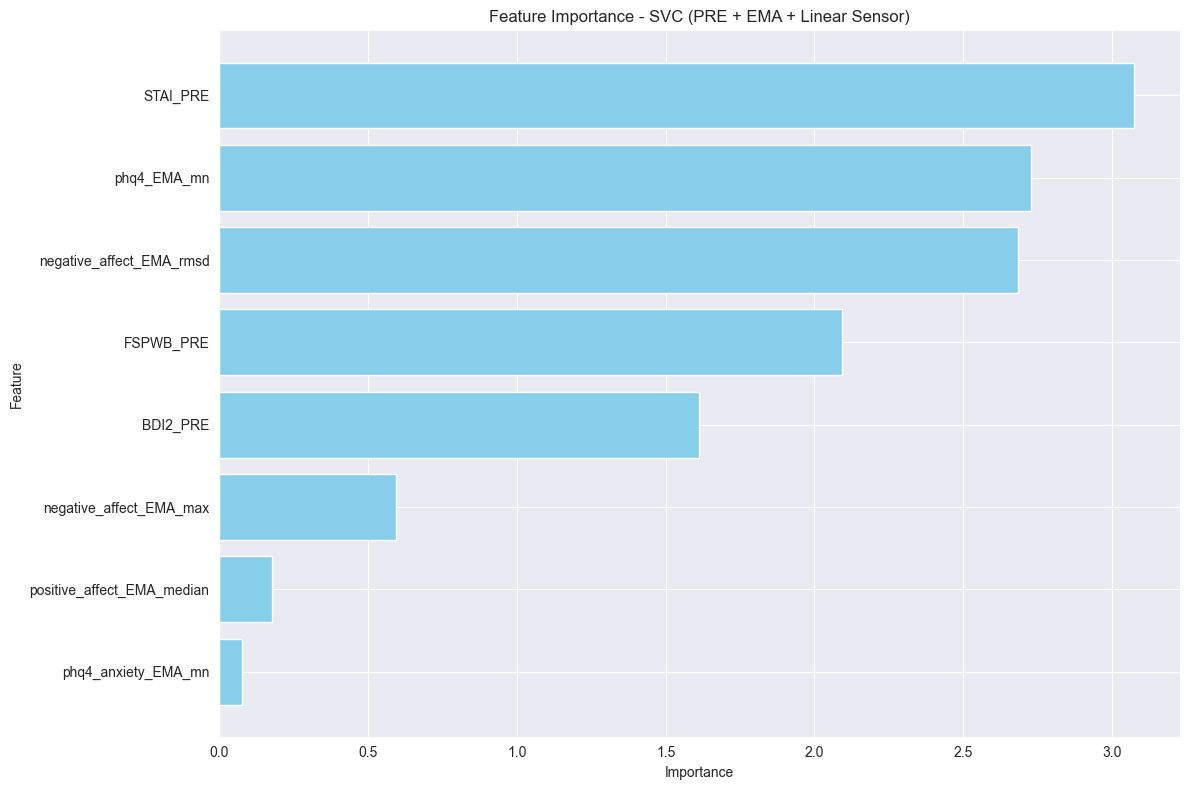

In [53]:
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_importance(model, feature_names, model_name, partition_name):
    """
    Plots feature importance for models like Logistic Regression and SVC.
    
    Parameters:
    model: trained model object
    feature_names: list of feature names used in training
    model_name: name of the model (e.g., 'Logistic Regression')
    partition_name: name of the data partition (e.g., 'PRE + EMA + Linear Sensor')
    """
    # Check if the model was tuned with RandomizedSearchCV
    if hasattr(model, 'best_estimator_'):
        model = model.best_estimator_  # Get the underlying model
    
    try:
        # For Logistic Regression and SVC with linear kernel
        if model_name == 'Logistic Regression' or (model_name == 'SVC' and model.kernel == 'linear'):
            importance = np.abs(model.coef_[0])
        else:
            print(f"Feature importance is not available for model {model_name}.")
            return

        # Sort feature importance in descending order
        sorted_indices = np.argsort(importance)[::-1]

        # Plotting
        plt.figure(figsize=(12, 8))
        plt.title(f"Feature Importance - {model_name} ({partition_name})")
        plt.barh(range(len(importance)), importance[sorted_indices], align='center', color='skyblue')
        plt.yticks(range(len(importance)), np.array(feature_names)[sorted_indices][::-1], rotation=0)
        plt.ylabel('Feature')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.gca().invert_yaxis()  # Ensures most important features are at the top
        plt.show()


    except AttributeError:
        print(f"Feature importance is not available for model {model_name}.")

# Example Usage for Logistic Regression and SVC on 'PRE + EMA + Linear Sensor' partition
partition_name = 'PRE + EMA + Linear Sensor'
model_name_log_reg = 'Logistic Regression'
model_name_svc = 'SVC'

# Get trained models from the dictionary
trained_log_reg = trained_models.get((partition_name, model_name_log_reg))
trained_svc = trained_models.get((partition_name, model_name_svc))

# Retrieve the selected features from the LASSO selection step
# This ensures that only the features used in training are considered for plotting
selected_features = selected_features_dict.get(partition_name)  # Assuming you have saved the selected features for each partition

# Plot feature importance for Logistic Regression
if trained_log_reg:
    plot_feature_importance(trained_log_reg, selected_features, model_name_log_reg, partition_name)

# Plot feature importance for SVC (if it is a linear kernel)
if trained_svc and hasattr(trained_svc.best_estimator_, 'kernel') and trained_svc.best_estimator_.kernel == 'linear':
    plot_feature_importance(trained_svc, selected_features, model_name_svc, partition_name)
